In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from tqdm import tqdm

try:
    import gym
except ImportError:
    %pip install gym
    import gym

# Import our classes
from random_agent import RandomAgent
from dqn_agent_base import DQNAgentBase
from dqn_agent_heuristic import DQNAgentHeuristic
from dqn_agent_rnd import DQNAgentRND
from dyna_agent import DynaAgent

%load_ext autoreload
%autoreload 2

In [2]:
# Plotting settings and device
sns.set_theme(style='whitegrid')
color_palette = plt.cm.tab10.colors
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # else gives error when trying to plot

## Define Environment by Gymnasium

[Environment Details](https://gymnasium.farama.org/environments/classic_control/mountain_car/)

Full Example on Github of the [Mountain Car](https://github.com/guillaumefrd/q-learning-mountain-car)

In [3]:
env = gym.make('MountainCar-v0', render_mode='human')

In [4]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Number of actions available: 3
Observation shape: (2,)


#### <span style="text-decoration:underline;">Explanations:</span>
- Observation space:
    - [-1.2 0.6] position range (in m)
    - [-0.07 0.07] velocity range (in v = m/s)
    - 2dim phase space (x-v-space)
- Actions:
    - 0: Accelerate to left
    - 1: Don't accelerate
    - 2: Accelerate to right
### <span style="text-decoration:underline;">Transition dynamics:</span>
<span style="text-decoration:underline;">Variables:</span>

Force $F$, action $a$, position $x$, velocity $v$, time (discrete) $t$, gravity $g$

The transition dynamics then reads:
$$
\begin{align}
v_{t+1} &= v_t + (a - 1)F - \cos(3x_t)g\\ 
x_{t+1} &= x_t + v_{t+1}
\end{align}
$$

Physical explanation:
- $ (a - 1) \implies$: -1: left, 0; no acceleration; +1: right acceleration; magnitude $F$
- Physically, the dimensions are an acceleration (setting $m=1$ and having a force balance of $\Delta v = v_{t+1}-v_t$)
- The last term is gravitational force, where the angle is expressed as $\alpha=3x$

#### <span style="text-decoration:underline;">Notes</span>
- The default reward setting is -1 per time step
- Environment acts stochastically, start position is in a fixed range

## Define the general functions

#### Plotting Functions

In [5]:
def plot_mean_reward_per_episode(reward_dict, window_size=25, ax=None):
    """
    reward_dict: dictionary containing the rewards per episode, optionally add environment and auxiliary rewards
    class_name: name of the class
    save_name: name to save the plot
    """
    if ax is None:
        _, ax = plt.subplots()
    for key in reward_dict:
        moving_avg = np.convolve(reward_dict[key], np.ones(window_size) / window_size, mode='valid')
        moving_CI = np.std(
            [reward_dict[key][i:i + window_size] for i in range(len(reward_dict[key]) - window_size + 1)], axis=1) / np.sqrt(window_size) * 1.96

        ax.plot(moving_avg, label=f'{key}'.replace("episodes_", ""))
        ax.fill_between(np.arange(len(moving_avg)), moving_avg - moving_CI, moving_avg + moving_CI, alpha=0.2)
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Accumulated rewards per episode')
    #if len(reward_dict) > 1:
    #    ax.legend()  # --> remove as it is plotted for cumulative reward already, looks better


def plot_cumulative_rewards(reward_dict, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    for key in reward_dict:
        cum_rewards = np.cumsum(reward_dict[key])
        ax.plot(cum_rewards, label=f'{key}'.replace("episodes_", ""))
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Cumulative rewards')
    if len(reward_dict) > 1:
        ax.legend()


def plot_training_loss(loss_dict, window_size=250, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    for key in loss_dict:
        moving_avg = np.convolve(loss_dict[key], np.ones(window_size) / window_size, mode='valid')
        moving_CI = np.std(
            [loss_dict[key][i:i + window_size] for i in range(len(loss_dict[key]) - window_size + 1)], axis=1) / np.sqrt(window_size) * 1.96

        ax.plot(moving_avg, label=f'{key}'.replace("training_", ""))
        ax.fill_between(np.arange(len(moving_avg)), moving_avg - moving_CI, moving_avg + moving_CI, alpha=0.2)
    ax.set_xlabel('Steps')
    ax.set_ylabel('MSE per step')
    if len(loss_dict) > 1:
        ax.legend() 


def plot_success(training_stats, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(training_stats['cumulative_successes'])
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative successes')

def plot_episode_duration(training_stats, ax=None):
    episodes = np.arange(len(training_stats['episodes_lengths']))
    if ax is None:
        _, ax = plt.subplots()
    ax.scatter(episodes, training_stats['episodes_lengths'], alpha=0.8, s=0.75)
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Steps taken')


def plot_q_values(q_values, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    im = ax.imshow(q_values, aspect='auto', origin='lower')

    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")

    ax.set_xticks(np.arange(0, 73, 8), np.arange(-1.2, 0.62, 0.025 * 8).round(3))
    ax.set_yticks(np.arange(0, 29, 7), np.arange(-0.07, 0.072, 0.005 * 7).round(3))

    ax.figure.colorbar(im)

def plot_env_reward_comparison(rewards_dict):
    fig = plt.figure(figsize=(10, 5))
    gs = GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    legend_handles = []
    for i, (agent_name, reward) in enumerate(rewards_dict.items()):
        plot_mean_reward_per_episode(reward, window_size=50, ax=ax1)
        plot_cumulative_rewards(reward, ax=ax2)

        legend_handles.append(plt.Line2D([0], [0], color=color_palette[i], label=f'{agent_name}'))

    fig.legend(title='Agent', handles=legend_handles, loc='upper right', bbox_to_anchor=(0.97, 0.88))

# Create list of possible keys for rewards
reward_keys = ['episodes_rewards', 'episodes_environment_rewards', 'episodes_auxiliary_rewards']
loss_keys = ['steps_dqn_loss', 'steps_rnd_loss']

## Define a Run function to run the Agent 

In [6]:
def run(agent, episodes, render=False, env_seeds=None):
    """
    Run the Agent through the environment
    :param agent: the agent to run on the environment
    :param episodes: number of episodes to run the algorithm
    :param render: boolean to render the environment or not
    :param env_seeds: list containing all environment random seeds. Needs a length of `episodes`.
    """

    # load the environment
    env = gym.make('MountainCar-v0', render_mode='human' if render else None)

    for episode_num in tqdm(range(episodes)):
        # Reset episode and episode's statistics
        if env_seeds is None:
            state, _ = env.reset()
        else:
            state, _ = env.reset(seed=env_seeds[episode_num])

        terminated = False
        truncated = False

        while not (terminated or truncated):
            # Select and take action based on agent's policy
            action = agent.select_action(state)
            next_state, environment_reward, terminated, truncated, _ = env.step(action)

            # Observe transition
            agent.observe(state, action, next_state, environment_reward, terminated, truncated)

            # Update state
            state = next_state   
        
    # Save the agent
    agent.save()

    env.close()

## Random Agent

#### Run the random agent for an episode and render it

In [12]:
random_agent = RandomAgent(env)
run(random_agent, 1, render=True)

100%|██████████| 1/1 [00:07<00:00,  7.12s/it]


#### Run the random Agent 100 times and plot the lengths of the episodes for different max lengths.

100%|██████████| 100/100 [00:00<00:00, 276.58it/s]


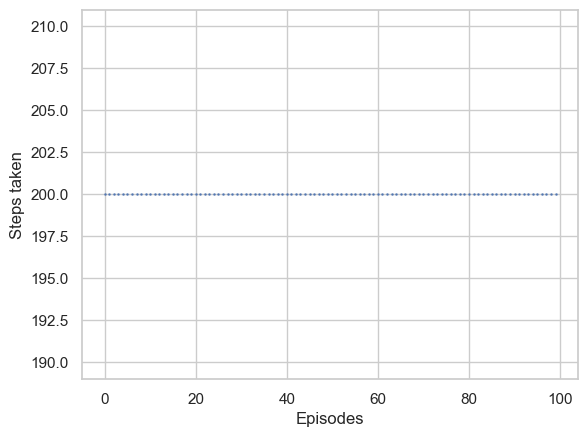

In [13]:
random_agent = RandomAgent(env)
run(random_agent, 100)
plot_episode_duration(random_agent.get_training_dict())

## DQN Agent without heuristic auxiliary reward

In [25]:
# Train the agent
dqn_agent_base = DQNAgentBase(env, trainable=True)
run(dqn_agent_base, 1000)

100%|██████████| 1000/1000 [12:00<00:00,  1.39it/s]


In [26]:
# Render the agent
dqn_agent_render_normal = DQNAgentBase(env, trainable=False, epsilon=0.0)
run(dqn_agent_render_normal, 1, render=True)

100%|██████████| 1/1 [00:07<00:00,  7.42s/it]


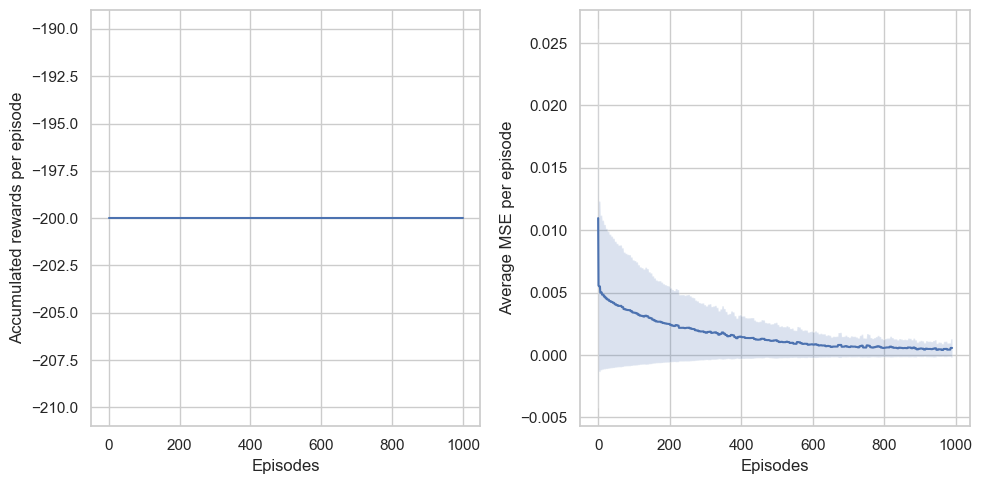

In [27]:
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

dqn_base_training_dict = dqn_agent_base.get_training_dict()

reward_dict = {'episodes_environment_rewards': dqn_base_training_dict['episodes_environment_rewards']}
loss_dict = {'steps_dqn_loss': dqn_base_training_dict['steps_dqn_loss']}

plot_mean_reward_per_episode(reward_dict, window_size=1, ax=ax1)
plot_training_loss(loss_dict, window_size=10, ax=ax2)

# Change the labels for this specific plot (asked about loss per episode I think)
ax2.set(xlabel='Episodes', ylabel='Average MSE per episode')

plt.tight_layout()

plt.savefig('figures/DQN_Agent_base.png')
plt.show()

- The Agent does not solve the problem
- As we never reach the goal and each step yields -1 reward, there is no learning in process as the Q-values will all be equal!

## DQN agent with heuristically chosen auxiliary reward 
- The chosen reward function is based on the total energy of the system
$$\begin{align*}
E_{tot} 
&= mgz + \dfrac{m}{2}\dot{x}^2\\
&= mg\sin(x) + \dfrac{m}{2}v^2\\
&\propto \alpha \sin(x) + \beta \dot{x}^2
\end{align*}$$
- We rescale in the following manner:
    - $E_{tot}$ must not exceed 1 $\implies$ all possible states should give negative rewards, finding the goal quickly has to remain the primary objective, hence we have to punish each step
    - As there is no given sense of time scale, we rescale the velocity such that maximum velocity at lowest position yields the same reward as highest position at zero velocity (this ensures energy conservation). This should motivate the agent to add energy to the system by accelerating in the right moment
    - Hence the position and velocity terms are restricted to an upper limit of $0.5$ each


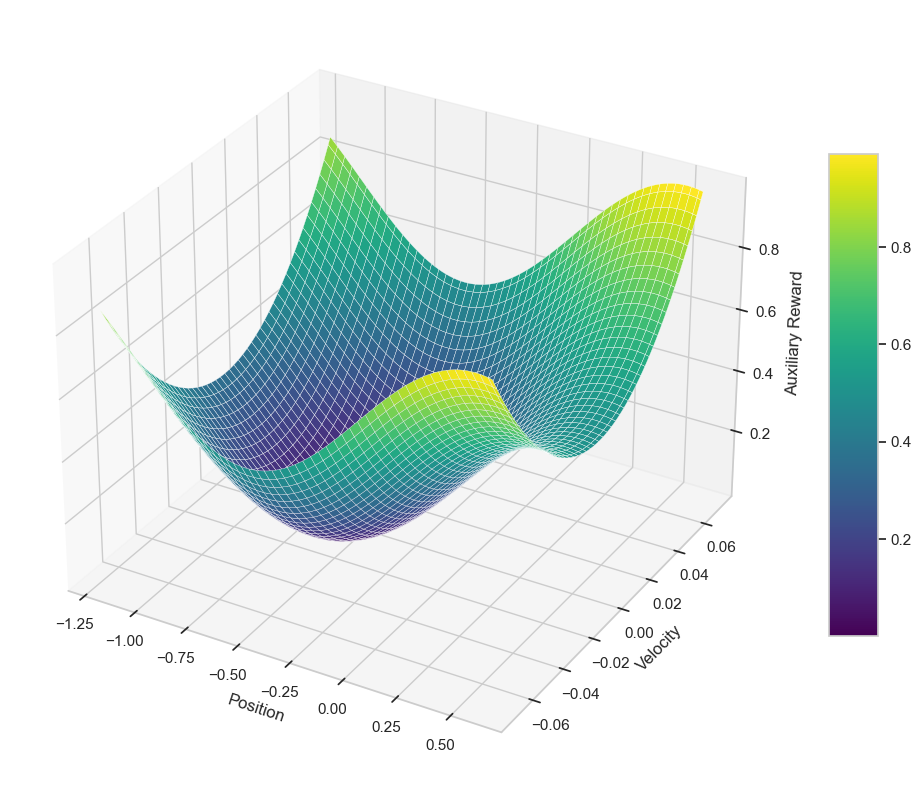

In [28]:
# Displaying the chosen reward function
x = np.linspace(-1.2, 0.6, 100)
y = np.linspace(-0.07, 0.07, 100)
X, Y = np.meshgrid(x, y)
Z = (np.sin(3 * X) + 1) / 4 + (Y*100/7) ** 2 / 2

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0.25, label='heuristic reward')
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('Auxiliary Reward')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.savefig('figures/auxiliary_reward_function.png')
plt.show()

In [13]:
dqn_agent_heuristic = DQNAgentHeuristic(env, trainable=True)
run(dqn_agent_heuristic, 3000)

100%|██████████| 3000/3000 [18:45<00:00,  2.67it/s]


In [14]:
# Render
dqn_agent_render_heuristic = DQNAgentHeuristic(env, trainable=False, epsilon=0.0)
run(dqn_agent_render_heuristic, 1, render=True)

100%|██████████| 1/1 [00:03<00:00,  3.92s/it]


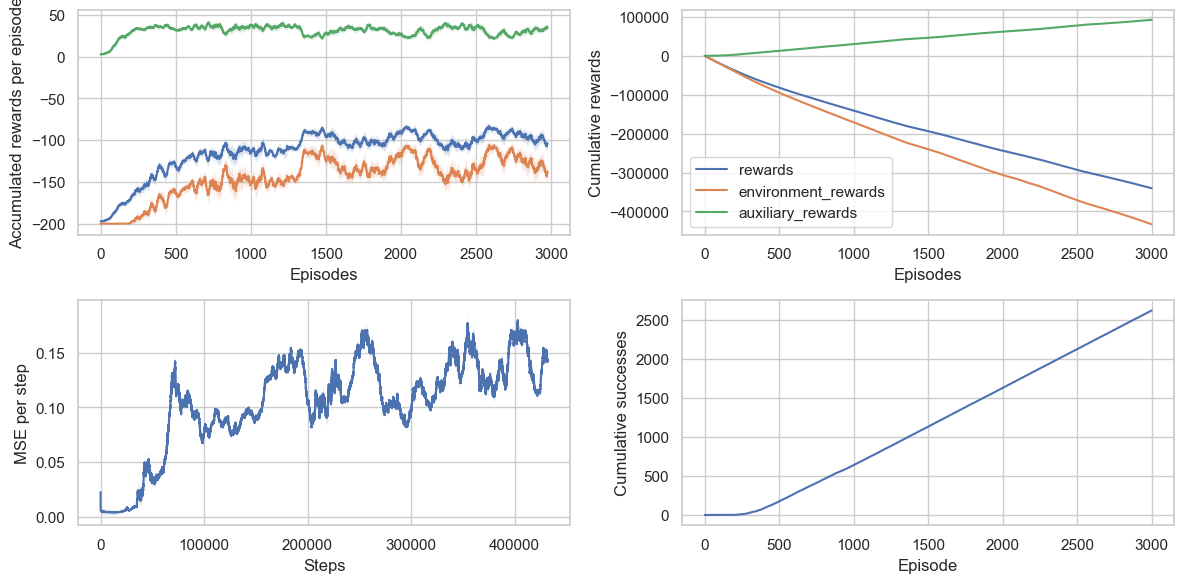

In [15]:
# plot results
heuristic_training_stats = dqn_agent_heuristic.get_training_dict()
heuristic_reward_dict = {key: heuristic_training_stats[key] for key in reward_keys}
heuristic_loss_dict = {'steps_dqn_loss': heuristic_training_stats['steps_dqn_loss']}

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

plot_mean_reward_per_episode(heuristic_reward_dict, ax=ax[0][0])
plot_cumulative_rewards(heuristic_reward_dict, ax=ax[0][1])
plot_training_loss(heuristic_loss_dict, window_size=1000, ax=ax[1][0])
plot_success(heuristic_training_stats, ax=ax[1][1])

plt.tight_layout()
plt.savefig('figures/DQN_Agent_heuristic.png')
plt.show()

## Heuristic reward with different auxiliary reward scalings

In [32]:
reward_factors = [0, 0.05, 0.1, 0.5, 1, 2.5, 5]
aux_dicts = {}
for reward_factor in reward_factors:
    dqn_agent_aux = DQNAgentHeuristic(env, trainable=True, domain_reward_factor=reward_factor, epsilon_decay=0.99997)  # Changed decay for 1000 episodes
    run(dqn_agent_aux, 1000)
    aux_dicts[f'heuristic_training_{reward_factor}'] = dqn_agent_aux.get_training_dict()

100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s]


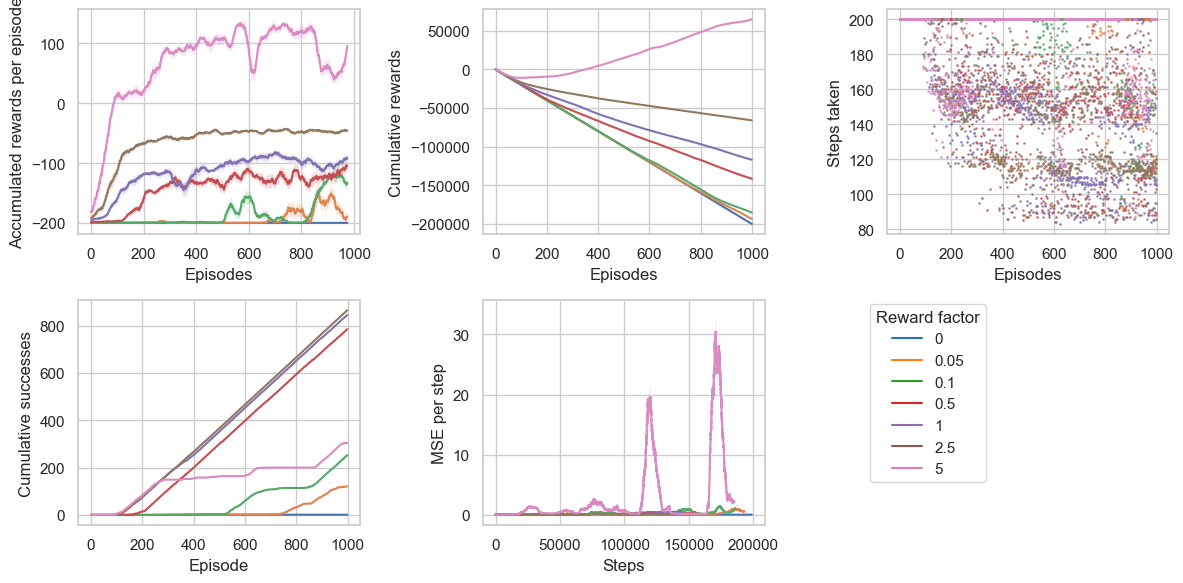

In [33]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

legend_handles = []
for i, reward_factor in enumerate(reward_factors):
    domain_reward_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in reward_keys[0:1]}
    domain_loss_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in loss_keys[0:1]}
    plot_mean_reward_per_episode(domain_reward_dicts, ax=ax[0][0])
    plot_cumulative_rewards(domain_reward_dicts, ax=ax[0][1])
    plot_training_loss(domain_loss_dicts, window_size=1000, ax=ax[1][1])
    plot_success(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[1][0])
    plot_episode_duration(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[0][2])
    legend_handles.append(plt.Line2D([0], [0], color=color_palette[i], label=f'{reward_factor}'))
fig.delaxes(ax[1][2])
legend = fig.legend(title='Reward factor', handles=legend_handles, loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/auxiliary_reward_variation.png')

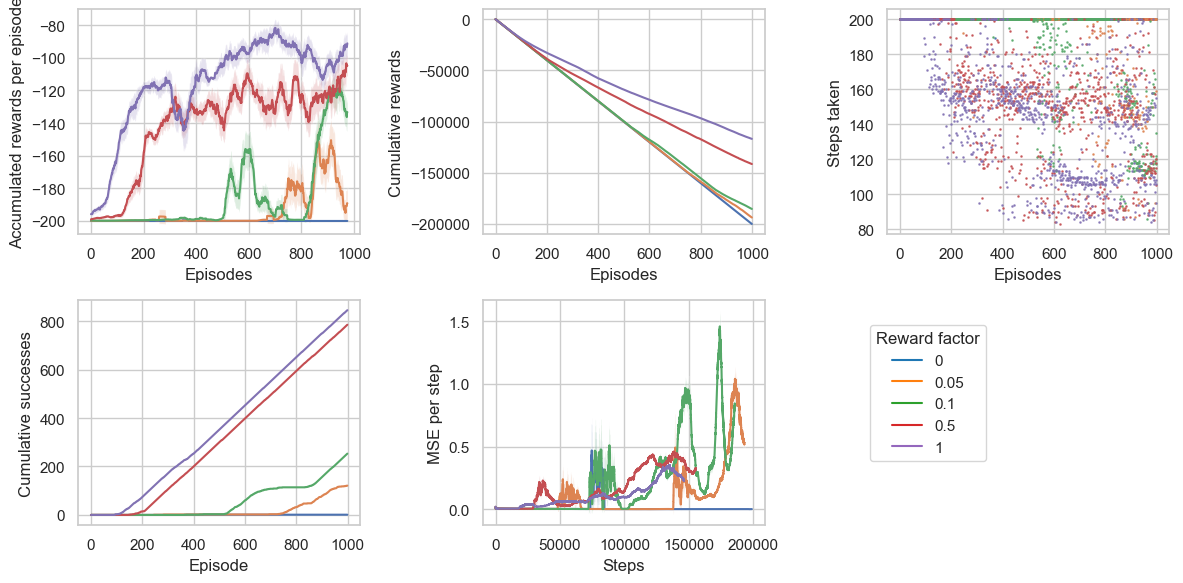

In [34]:
# repeat previous plots without the > 1 reward factors
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

legend_handles = []
for i, reward_factor in enumerate(reward_factors[0:5]):
    domain_reward_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in reward_keys[0:1]}
    domain_loss_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in loss_keys[0:1]}
    plot_mean_reward_per_episode(domain_reward_dicts, ax=ax[0][0])
    plot_cumulative_rewards(domain_reward_dicts, ax=ax[0][1])
    plot_training_loss(domain_loss_dicts, window_size=1000, ax=ax[1][1])
    plot_success(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[1][0])
    plot_episode_duration(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[0][2])
    legend_handles.append(plt.Line2D([0], [0], color=color_palette[i], label=f'{reward_factor}'))
fig.delaxes(ax[1][2])
legend = fig.legend(title='Reward factor', handles=legend_handles, loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/auxiliary_reward_variation_below1.png')

## Implementing Random Network Distillation (RND)

#### Start by playing with the reward factor to have an idea of good values

In [16]:
reward_factors = [0.1, 0.2, 1, 5, 10]
aux_dicts = {}
for reward_factor in reward_factors:
    dqn_agent_rnd = DQNAgentRND(env, trainable=True, reward_factor=reward_factor, epsilon_decay=0.99997)  # Changed decay for 1000 episodes
    run(dqn_agent_rnd, 1000)
    aux_dicts[f'heuristic_training_{reward_factor}'] = dqn_agent_rnd.get_training_dict()

100%|██████████| 1000/1000 [12:14<00:00,  1.36it/s]


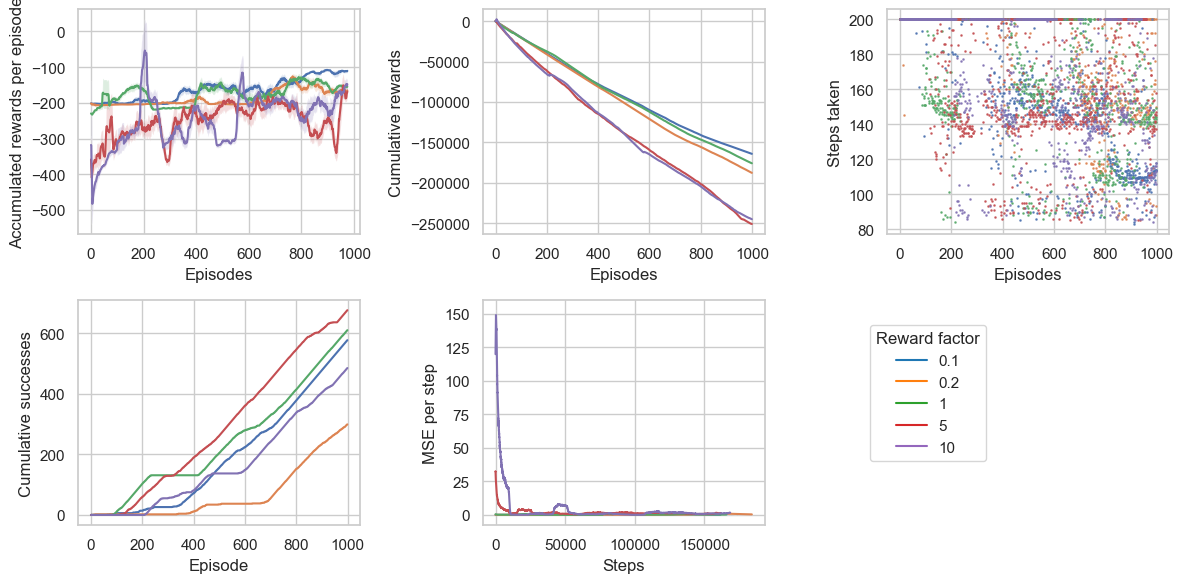

In [17]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

legend_handles = []
for i, reward_factor in enumerate(reward_factors):
    domain_reward_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in reward_keys[0:1]}
    domain_loss_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in loss_keys[0:1]}
    plot_mean_reward_per_episode(domain_reward_dicts, ax=ax[0][0])
    plot_cumulative_rewards(domain_reward_dicts, ax=ax[0][1])
    plot_training_loss(domain_loss_dicts, window_size=1000, ax=ax[1][1])
    plot_success(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[1][0])
    plot_episode_duration(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[0][2])
    legend_handles.append(plt.Line2D([0], [0], color=color_palette[i], label=f'{reward_factor}'))
fig.delaxes(ax[1][2])
legend = fig.legend(title='Reward factor', handles=legend_handles, loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/rnd_reward_variation.png')

#### Train an agent for 3000 episodes

In [18]:
dqn_agent_RND = DQNAgentRND(env, trainable=True)
run(dqn_agent_RND, 3000)

100%|██████████| 3000/3000 [30:39<00:00,  1.63it/s]


In [19]:
# Render
dqn_agent_render_RND = DQNAgentRND(env, trainable=False, epsilon=0.0)
run(dqn_agent_render_RND, 1, render=True)

100%|██████████| 1/1 [00:05<00:00,  5.23s/it]


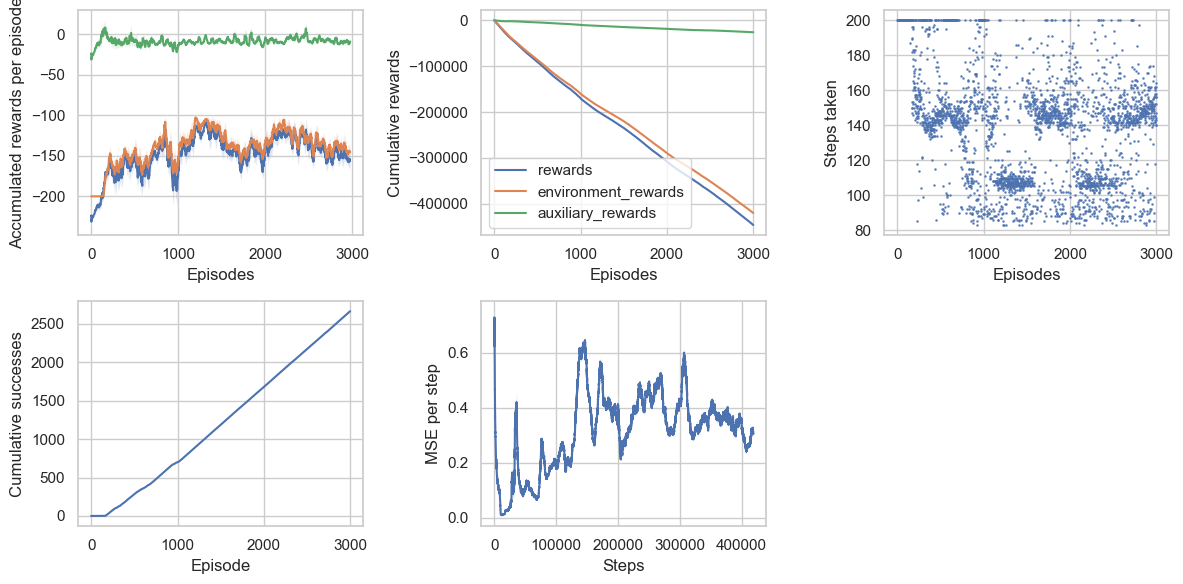

In [20]:
RND_training_stats = dqn_agent_RND.get_training_dict()

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

RND_rewards = {key: RND_training_stats[key] for key in reward_keys}
RND_losses = {'steps_dqn_loss': RND_training_stats['steps_dqn_loss']}
plot_mean_reward_per_episode(RND_rewards, ax=ax[0][0])
plot_cumulative_rewards(RND_rewards, ax=ax[0][1])
plot_training_loss(RND_losses, window_size=1000, ax=ax[1][1])
plot_success(RND_training_stats, ax=ax[1][0])
plot_episode_duration(RND_training_stats, ax=ax[0][2])
fig.delaxes(ax[1][2])
#legend = fig.legend(title='Reward factor', loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/DQNAgent_RND.png')

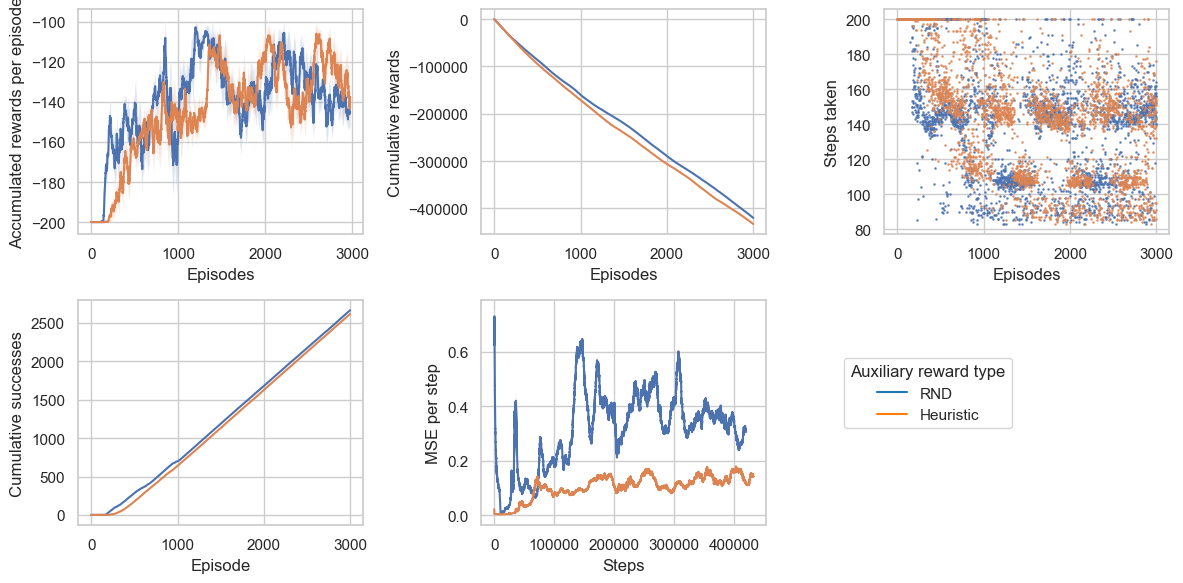

In [21]:
# compare RND to auxiliary
env_rewards_comp = {'episodes_environment_rewards RND': RND_training_stats['episodes_environment_rewards'],
                    'episodes_environment_rewards heuristic': heuristic_reward_dict['episodes_environment_rewards']}
losses_comp = {'steps_dqn_loss RND': RND_training_stats['steps_dqn_loss'],
               'steps_dqn_loss heuristic': heuristic_loss_dict['steps_dqn_loss']}

env_rewards_RND = {'episodes_environment_rewards': RND_training_stats['episodes_environment_rewards']}
env_rewards_heuristic = {'episodes_environment_rewards': heuristic_training_stats['episodes_environment_rewards']}
losses_RND = {'steps_dqn_loss': RND_training_stats['steps_dqn_loss']}
losses_heuristic = {'steps_dqn_loss': heuristic_training_stats['steps_dqn_loss']}

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)

ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

plot_mean_reward_per_episode(env_rewards_RND, ax=ax[0][0])
plot_mean_reward_per_episode(env_rewards_heuristic, ax=ax[0][0])
plot_cumulative_rewards(env_rewards_RND, ax=ax[0][1])
plot_cumulative_rewards(env_rewards_heuristic, ax=ax[0][1])
plot_training_loss(losses_RND, window_size=1000, ax=ax[1][1])
plot_training_loss(losses_heuristic, window_size=1000, ax=ax[1][1])
plot_success(RND_training_stats, ax=ax[1][0])
plot_success(heuristic_training_stats, ax=ax[1][0])
plot_episode_duration(RND_training_stats, ax=ax[0][2])
plot_episode_duration(heuristic_training_stats, ax=ax[0][2])
fig.delaxes(ax[1][2])
# create legend
legend_handles = [plt.Line2D([0], [0], color=color_palette[0], label='RND'),
                  plt.Line2D([0], [0], color=color_palette[1], label='Heuristic')]
legend = fig.legend(handles=legend_handles, title='Auxiliary reward type', loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/RND_vs_auxiliary.png')
plt.show()

### DYNA Algorithm

#### Play with different discretization steps

In [7]:
# Train different discr. steps agents
discr_steps_list = [(0.025 * 4, 0.02 * 4), (0.025, 0.005), (0.025 / 3, 0.005 / 3)] # Memory issue with more states than the last
# number of states [(18, 7), (72, 28), (288, 112)]

dyna_dicts = {}
for discr_steps in discr_steps_list:
    # Train agent for 1000 episodes
    dyna_agent = DynaAgent(env, trainable=True, discr_step=discr_steps, epsilon_decay=0.99997)
    run(dyna_agent, 1000)
    dyna_dicts[f'dyna_training_{discr_steps}'] = dyna_agent.get_training_dict()

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\dgeno\miniconda3\envs\mnlp\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1000/1000 [25:28<00:00,  1.53s/it]


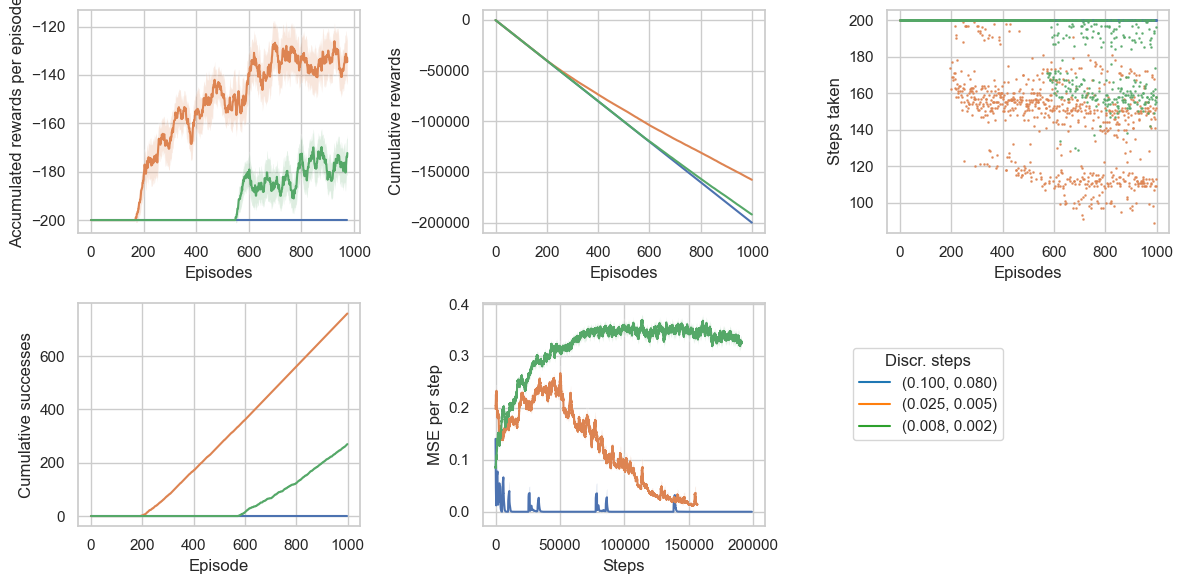

In [8]:
# Plot the agents' training stats
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

legend_handles = []
for i, discr_steps in enumerate(discr_steps_list):
    # Plot the stats
    dyna_training_stats = dyna_dicts[f'dyna_training_{discr_steps}']
    dyna_rewards = {'episodes_environment_rewards': dyna_training_stats['episodes_environment_rewards']}
    dyna_loss = {'steps_dqn_loss': dyna_training_stats['steps_dqn_loss']}
    plot_mean_reward_per_episode(dyna_rewards, ax=ax[0][0])
    plot_cumulative_rewards(dyna_rewards, ax=ax[0][1])
    plot_training_loss(dyna_loss, window_size=1000, ax=ax[1][1])
    plot_success(dyna_training_stats, ax=ax[1][0])
    plot_episode_duration(dyna_training_stats, ax=ax[0][2])
    legend_handles.append(plt.Line2D([0], [0], color=color_palette[i], label=f'({discr_steps[0]:.3f}, {discr_steps[1]:.3f})'))

fig.delaxes(ax[1][2])
legend = fig.legend(title='Discr. steps', handles=legend_handles, loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/Dyna_discr_steps_variation.png')

#### Train an agent for 3000 episodes

In [236]:
# Train agent for 3000 episodes
snapshot_episodes = (100, 500, 1000, 3000)
dyna_agent = DynaAgent(env, trainable=True, snapshot_episodes=snapshot_episodes)
run(dyna_agent, 3000)

  0%|          | 0/3000 [00:00<?, ?it/s]C:\Users\dgeno\miniconda3\envs\mnlp\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 3000/3000 [08:27<00:00,  5.91it/s]


In [237]:
# Render
dyna_agent_render = DynaAgent(env, trainable=False, epsilon=0.0)
run(dyna_agent_render, 1, render=True)

100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


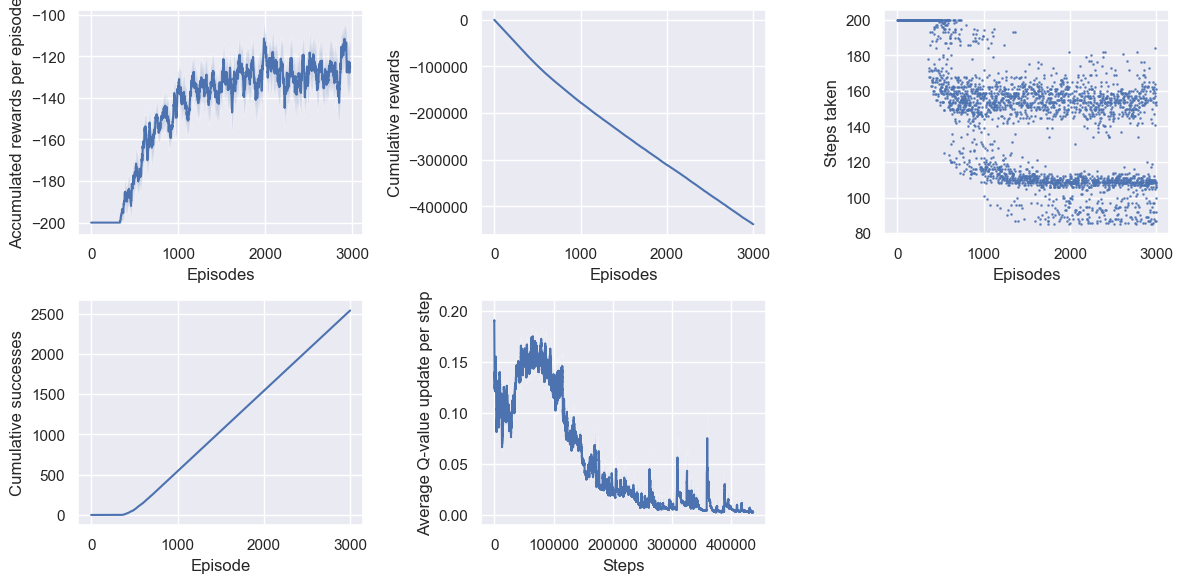

In [244]:
# Plot as before
dyna_training_stats = dyna_agent.get_training_dict()

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

dyna_rewards = {'episodes_environment_rewards': dyna_training_stats['episodes_environment_rewards']}
dyna_loss = {'steps_dqn_loss': dyna_training_stats['steps_dqn_loss']}
plot_mean_reward_per_episode(dyna_rewards, ax=ax[0][0])
plot_cumulative_rewards(dyna_rewards, ax=ax[0][1])
plot_training_loss(dyna_loss, window_size=1000, ax=ax[1][1])
plot_success(dyna_training_stats, ax=ax[1][0])
plot_episode_duration(dyna_training_stats, ax=ax[0][2])
fig.delaxes(ax[1][2])

# Change the label, as it is not the loss for Dyna
ax[1][1].set(ylabel='Average Q-value update per step')

plt.tight_layout()
plt.savefig('figures/DynaAgent.png')

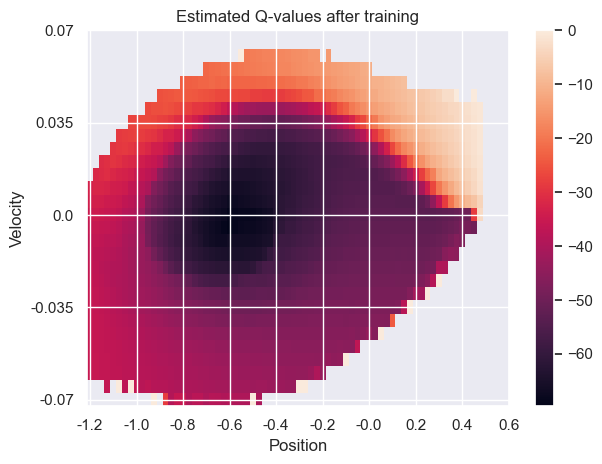

In [239]:
# Plot the Q-values after training
dyna_training_stats = dyna_agent.get_training_dict()

# Get the Q-values
q_values = np.transpose(dyna_training_stats['q_values_snapshots'][3]).copy()

# Plot the Q-values
_, ax = plt.subplots()

im = ax.imshow(q_values, aspect='auto', origin='lower')

ax.set_xlabel("Position")
ax.set_ylabel("Velocity")

ax.set_xticks(np.arange(0, 73, 8), np.arange(-1.2, 0.62, 0.025 * 8).round(3))
ax.set_yticks(np.arange(0, 29, 7), np.arange(-0.07, 0.072, 0.005 * 7).round(3))

ax.figure.colorbar(im)
plt.title("Estimated Q-values after training")
plt.tight_layout()

plt.savefig('figures/Dyna_Agent_Q_values_after_train.png')

#### Dyna trajectories progression during training

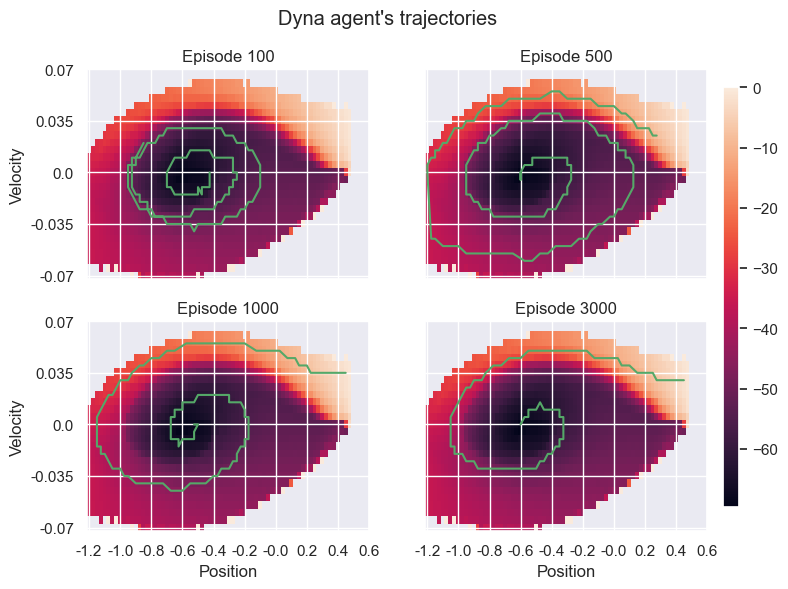

In [240]:
# Plot the trajectories

fig = plt.figure(figsize=(8, 6))
gs = GridSpec(2, 2, figure=fig)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

for i, episode in enumerate(snapshot_episodes):
    ax = axes[i // 2][i % 2]

    # Plot the Q-values
    im = ax.imshow(q_values, aspect='auto', origin='lower')

    # Plot the trajectory
    trajectory = np.transpose(dyna_training_stats['trajectories_snapshots'][i])
    traj_pos = trajectory[0]
    traj_vel = trajectory[1]
    ax.plot(traj_pos, traj_vel, 'g')

    ax.set_title(f'Episode {episode}')

    ax.set_xticks(np.arange(0, 73, 8))
    ax.set_xticklabels(np.arange(-1.2, 0.62, 0.025 * 8).round(3))
    if i // 2 == 1:
        ax.set_xlabel("Position")
    else:
        ax.tick_params(which='both', labelbottom=False)

    ax.set_yticks(np.arange(0, 29, 7))
    ax.set_yticklabels(np.arange(-0.07, 0.072, 0.005 * 7).round(3))
    if i % 2 == 0:
        ax.set_ylabel("Velocity")
    else:
        ax.tick_params(labelleft=False) 

# Add the color bar to the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle("Dyna agent's trajectories")

plt.savefig('figures/Dyna_Agent_trajectories.png')

#### Dyna Q-values progression during training

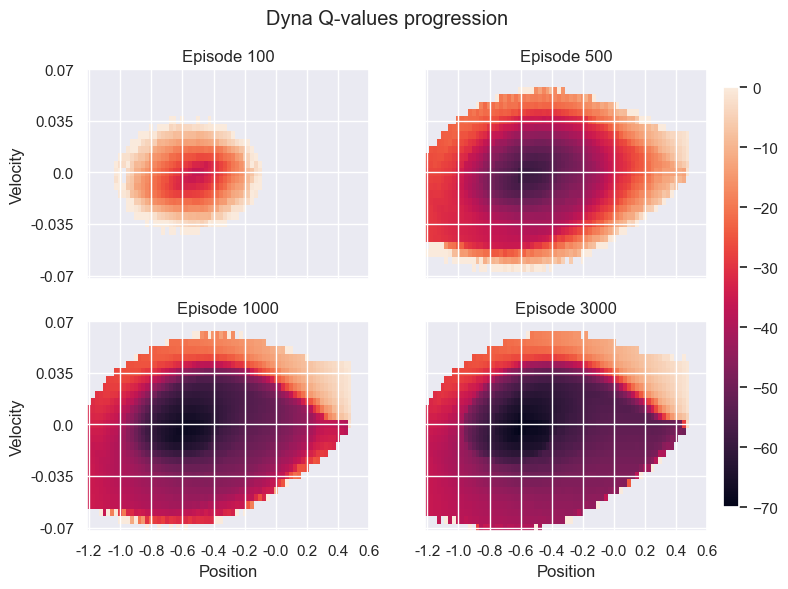

In [246]:
# Bonus: Plot the Q-values progression

fig = plt.figure(figsize=(8, 6))
gs = GridSpec(2, 2, figure=fig)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

for i, episode in enumerate(snapshot_episodes):
    ax = axes[i // 2][i % 2]
    q_values = np.transpose(dyna_training_stats['q_values_snapshots'][i]).copy()

    # Plot the Q-values
    im = ax.imshow(q_values, aspect='auto', origin='lower', vmax=0, vmin=-70)

    ax.set_title(f'Episode {episode}')

    ax.set_xticks(np.arange(0, 73, 8))
    ax.set_xticklabels(np.arange(-1.2, 0.62, 0.025 * 8).round(3))
    if i // 2 == 1:
        ax.set_xlabel("Position")
    else:
        ax.tick_params(which='both', labelbottom=False)

    ax.set_yticks(np.arange(0, 29, 7))
    ax.set_yticklabels(np.arange(-0.07, 0.072, 0.005 * 7).round(3))
    if i % 2 == 0:
        ax.set_ylabel("Velocity")
    else:
        ax.tick_params(labelleft=False)
        
    if i == 0:
        #Add the color bar to the right
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax)


plt.suptitle("Dyna Q-values progression")

plt.savefig('figures/Dyna_Agent_Q_values_progression.png')

## Agents comparisons

#### Training

In [9]:
# Create the agents
dqn_heuristic_agent_train = DQNAgentHeuristic(env, trainable=True)
dqn_rnd_agent_train = DQNAgentRND(env, trainable=True)
dyna_agent_train = DynaAgent(env, trainable=True)

train_rewards_dict = {}

# Train the agents
run(dqn_heuristic_agent_train, 3000)
train_rewards_dict['DQN Heuristic'] = {'episodes_environment_rewards': dqn_heuristic_agent_train.get_training_dict()['episodes_environment_rewards']}

run(dqn_rnd_agent_train, 3000)
train_rewards_dict['DQN RND'] = {'episodes_environment_rewards': dqn_rnd_agent_train.get_training_dict()['episodes_environment_rewards']}

run(dyna_agent_train, 3000)
train_rewards_dict['Dyna'] = {'episodes_environment_rewards': dyna_agent_train.get_training_dict()['episodes_environment_rewards']}

100%|██████████| 3000/3000 [08:14<00:00,  6.06it/s]


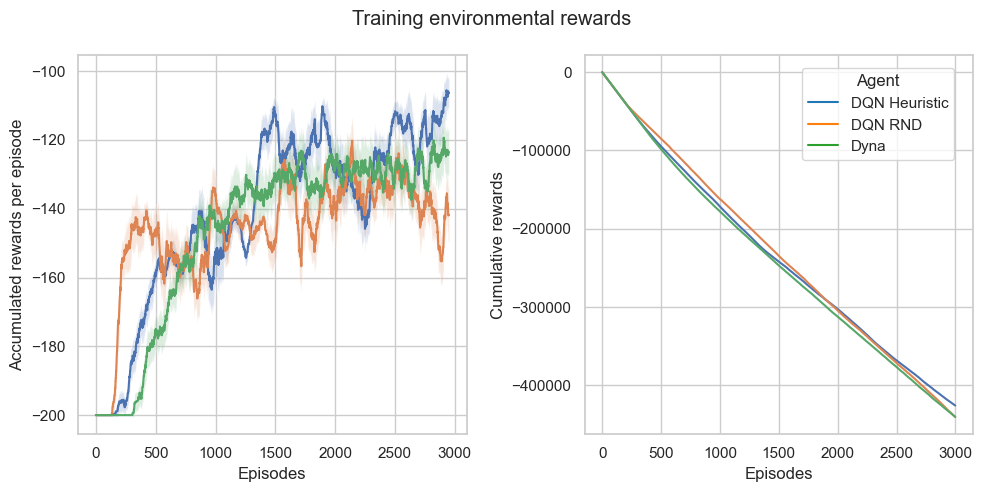

In [10]:
# Plot the environment rewards
plot_env_reward_comparison(train_rewards_dict)
plt.suptitle("Training environmental rewards")
plt.tight_layout()
plt.savefig('figures/agents_training_reward_comparison.png')

#### Testing

In [11]:
# Run the agents in testing environment

# Create the seeds
env_seeds = np.random.randint(0, high=1e6, size=1000).tolist()

# Create the agents
dqn_heuristic_agent_test = DQNAgentHeuristic(env, trainable=False, epsilon=0.0)
dqn_rnd_agent_test= DQNAgentRND(env, trainable=False, epsilon=0.0)
dyna_agent_test = DynaAgent(env, trainable=False, epsilon=0.0)

test_rewards_dict = {}

# Run the agents
run(dqn_heuristic_agent_test, 1000, env_seeds=env_seeds)
test_rewards_dict['DQN Heuristic'] = {'episodes_environment_rewards': dqn_heuristic_agent_test.get_training_dict()['episodes_environment_rewards']}

run(dqn_rnd_agent_test, 1000, env_seeds=env_seeds)
test_rewards_dict['DQN RND'] = {'episodes_environment_rewards': dqn_rnd_agent_test.get_training_dict()['episodes_environment_rewards']}

run(dyna_agent_test, 1000, env_seeds=env_seeds)
test_rewards_dict['Dyna'] = {'episodes_environment_rewards': dyna_agent_test.get_training_dict()['episodes_environment_rewards']}

100%|██████████| 1000/1000 [00:10<00:00, 95.01it/s]


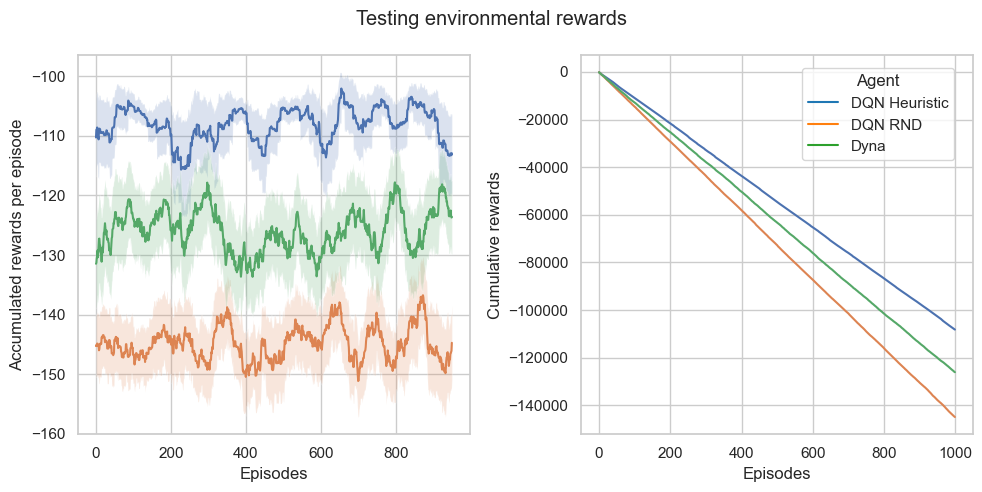

In [12]:
# Plot the environment rewards
plot_env_reward_comparison(test_rewards_dict)
plt.suptitle("Testing environmental rewards")
plt.tight_layout()
plt.savefig('figures/agents_testing_reward_comparison.png')